In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader,Dataset
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import time

In [2]:
device = torch.device('cpu')
torch.manual_seed(1)

torch.Size([64, 1, 28, 28])


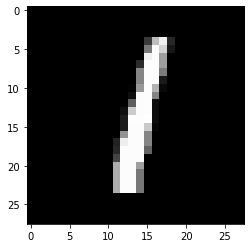

In [3]:
MNIST_data = torchvision.datasets.MNIST(root= './Datasets', download=True, transform = transforms.Compose([transforms.ToTensor(),\
transforms.Normalize((0.1307,), (0.3081, )) ]))
data_loader = DataLoader(MNIST_data, batch_size=64, shuffle = True)
test_loader = DataLoader(torchvision.datasets.MNIST('./Datasets', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])), batch_size=10, shuffle = True)
iterator = iter(data_loader)
images, labels = iterator.next()
plt.imshow(images[5].reshape(28, 28), cmap = "gray")
print(images.shape)
#learn more about matplotlib if you can !!
#what is plt.imshow , how do i use it more efficiently

In [4]:
print(images[0][0][np.where(images[0].reshape(28, 28) > 0)])

tensor([1.4850, 0.3013, 2.1469, 0.9632, 2.8088, 0.9632, 0.3777, 2.8088, 0.1613,
        0.1104, 1.7523, 0.1740, 0.5049, 2.8088, 0.6959, 1.6887, 2.8088, 0.9632,
        0.5049, 2.8088, 0.9632, 2.3505, 2.8215, 0.8359, 0.5049, 2.8088, 0.0340,
        2.7324, 2.4142, 1.0395, 2.8088, 0.0340, 0.7086, 2.8088, 1.9560, 1.4214,
        2.3505, 1.7523, 2.7960, 0.3777, 2.0832, 2.0832, 2.5415, 2.8088, 0.0467,
        0.0467, 2.8088, 1.4214, 1.0395, 2.7960, 2.7960, 2.8088, 2.4015, 1.6887,
        0.6322, 0.0467, 2.7960, 1.4214, 1.4214, 2.8088, 1.0904, 1.1668, 1.6887,
        2.5542, 2.8088, 2.8088, 2.2742, 2.2869, 2.8088, 1.1032, 1.4214, 2.7960,
        0.0340, 1.3450, 1.3450, 1.6123, 2.5415, 2.7960, 2.8088, 2.6687, 0.1104,
        0.9123, 1.8160, 2.5542, 2.1469, 0.1104, 2.8088, 1.3450, 1.0395, 2.8088,
        0.3013, 2.3378, 2.4142, 2.3505, 1.9560, 2.3378, 1.4214])


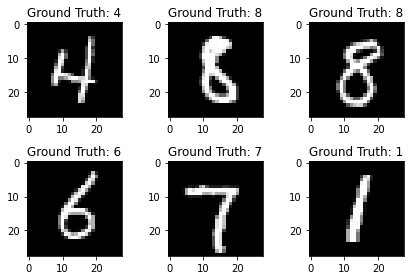

In [5]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(images[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(labels[i]))
#   plt.xticks([])
#   plt.yticks([])

In [6]:
class net(torch.nn.Module):
    def __init__(self):
        super(net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10 , kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320) 
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training= self.training) # this dropout obviously occurs ony during the training phase
        x = self.fc2(x) # => ooutput will be n , 10 
        return F.log_softmax(x)

In [7]:
# 28 - 5 + 1 = 24 -> 24 - 2 + 1 = 23 ->  23 -5 + 1 = 19 -> 19 - 2 + 1 -> 18 -> 324 somehoww , not a square of a number bro ! 


In [8]:
NeuralNet = net()
opt = torch.optim.SGD(NeuralNet.parameters(), lr = 1.2e-3)
log_interval = 100
train_loss_history= []
train_counter= []
test_loss_history = []
test_counter = []
#amazing way of storing the losses , using the batch id !



In [9]:
def train(epoch):
    #every element in images is a batch, the data loader gives you a batch outside!
    NeuralNet.train() # sets the training mode !
    for batch_id,(batch,labels) in enumerate(data_loader):
        opt.zero_grad() ###super important, work with the optimizer instead of the model
        y_pred = NeuralNet(batch)
        loss_fn = F.nll_loss # => this takes the class number !!
        loss = loss_fn(y_pred,labels)
        loss.backward()
        opt.step()
        if(batch_id % log_interval == 0):
            counter = 64*(batch_id)  + (epoch - 1)*len(data_loader.dataset) #very cool , what is this train_loader.dataset ( prolly only the second part)
            train_loss_history.append(loss.item())
            print("Epoch = %d, training counter = %d, training loss = %.6f, "%(epoch,counter,loss.item()))
            train_counter.append(counter)    


In [10]:
def test():
    NeuralNet.eval() #this is now in evaluation mode 
    loss = 0
    correct = 0
    avg_loss = 0
    for test_data, labels in test_loader:
        preds = NeuralNet(test_data)
        loss = F.nll_loss(preds,labels)
        correct = correct + (torch.argmax(preds, axis = 1) == labels).sum()
        avg_loss += loss/len(test_loader.dataset)
        test_loss_history.append(loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))


In [11]:
len(test_loader.dataset)

10000

In [12]:
F.nll_loss(torch.randn(3, 5), torch.tensor([1, 2, 3]))# at least one dimension must match! 
torch.argmax(torch.tensor([1, 2, 3]) , axis = 0, keepdim = True).shape 

torch.Size([1])

In [13]:
# for batch_id,(batch_data, labels) in enumerate(data_loader):
#     print(torch.argmax(NeuralNet(batch_data), axis = 1)== labels) #turns out the keepdim will keep the dim !, dont use keepdim unless necessary !
test()
num_epochs = 3
for epoch in range(1,num_epochs + 1):
    start_time = time.time()
    train(epoch)
    end_time = time.time()
    print("Time taken for epochs = ", end_time - start_time)
    test()


/tmp/ipykernel_48136/3904927278.py:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 2.3798, Accuracy: 924/10000 (9%)

Epoch = 1, training counter = 0, training loss = 2.342138, 
Epoch = 1, training counter = 6400, training loss = 2.327022, 
Epoch = 1, training counter = 12800, training loss = 2.282116, 
Epoch = 1, training counter = 19200, training loss = 2.298983, 
Epoch = 1, training counter = 25600, training loss = 2.286688, 
Epoch = 1, training counter = 32000, training loss = 2.249655, 
Epoch = 1, training counter = 38400, training loss = 2.272996, 
Epoch = 1, training counter = 44800, training loss = 2.225666, 
Epoch = 1, training counter = 51200, training loss = 2.211878, 
Epoch = 1, training counter = 57600, training loss = 2.252531, 
Time taken for epochs =  12.505971670150757

Test set: Avg. loss: 2.0889, Accuracy: 5232/10000 (52%)

Epoch = 2, training counter = 60000, training loss = 2.221323, 
Epoch = 2, training counter = 66400, training loss = 2.164381, 
Epoch = 2, training counter = 72800, training loss = 2.098022, 
Epoch = 2, trai

In [14]:
test()

/tmp/ipykernel_48136/3904927278.py:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 0.7945, Accuracy: 8396/10000 (84%)



<class 'list'>


Text(0.5, 1.0, 'Training Loss per batch versus number of examples seen')

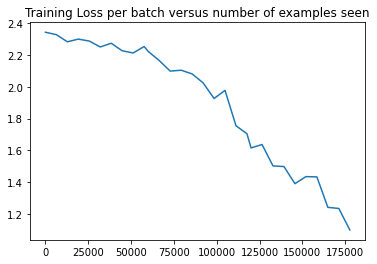

In [15]:
plt.plot(train_counter, train_loss_history)
print(type(train_counter))
plt.title("Training Loss per batch versus number of examples seen")

In [16]:
# for batch_id,(_,_) in enumerate(data_loader):
#     print(batch_id) # 0 - indexd !
import matplotlib.pyplot  as plt2
listx = [i for i in range(1, len(test_loss_history) + 1)]
